The following cell imports the packages that you will need.

In [40]:
%matplotlib inline
import glob
import os.path
import collections
import numpy
import netCDF4
import keras.layers
import keras.backend as K
import matplotlib.colors
import matplotlib.pyplot as pyplot
from gewittergefahr.gg_utils import error_checking

The following cell defines the constants that you will need.

In [2]:
NO_FRONT_ENUM = 0
WARM_FRONT_ENUM = 1
COLD_FRONT_ENUM = 2

NUM_BATCHES_PER_DIRECTORY = 1000
BATCH_NUMBER_REGEX = '[0-9][0-9][0-9][0-9][0-9][0-9][0-9]'

TEMPERATURE_NAME = 'temperature_kelvins'
HEIGHT_NAME = 'height_m_asl'
SPECIFIC_HUMIDITY_NAME = 'specific_humidity_kg_kg01'
WET_BULB_THETA_NAME = 'wet_bulb_potential_temperature_kelvins'
U_WIND_GRID_RELATIVE_NAME = 'u_wind_grid_relative_m_s01'
V_WIND_GRID_RELATIVE_NAME = 'v_wind_grid_relative_m_s01'

VALID_PREDICTOR_NAMES = [
    TEMPERATURE_NAME, HEIGHT_NAME, SPECIFIC_HUMIDITY_NAME, WET_BULB_THETA_NAME,
    U_WIND_GRID_RELATIVE_NAME, V_WIND_GRID_RELATIVE_NAME
]

PREDICTOR_MATRIX_KEY = 'predictor_matrix'
TARGET_MATRIX_KEY = 'target_matrix'
TARGET_TIMES_KEY = 'target_times_unix_sec'
ROW_INDICES_KEY = 'row_indices'
COLUMN_INDICES_KEY = 'column_indices'
PREDICTOR_NAMES_KEY = 'narr_predictor_names'
NARR_MASK_KEY = 'narr_mask_matrix'
PRESSURE_LEVEL_KEY = 'pressure_level_mb'
DILATION_DISTANCE_KEY = 'dilation_distance_metres'

FIGURE_WIDTH_INCHES = 15
FIGURE_HEIGHT_INCHES = 15

FONT_SIZE = 30
pyplot.rc('font', size=FONT_SIZE)
pyplot.rc('axes', titlesize=FONT_SIZE)
pyplot.rc('axes', labelsize=FONT_SIZE)
pyplot.rc('xtick', labelsize=FONT_SIZE)
pyplot.rc('ytick', labelsize=FONT_SIZE)
pyplot.rc('legend', fontsize=FONT_SIZE)
pyplot.rc('figure', titlesize=FONT_SIZE)

EDGE_DETECTOR_MATRIX1 = numpy.array([[-1, -1, -1],
                                     [-1, 8, -1],
                                     [-1, -1, -1]], dtype=float)
EDGE_DETECTOR_MATRIX2 = numpy.array([[1, 0, -1],
                                     [0, 0, 0],
                                     [-1, 0, 1]], dtype=float)
EDGE_DETECTOR_MATRIX3 = numpy.array([[0, 1, 0],
                                     [1, -4, 1],
                                     [0, 1, 0]], dtype=float)

The following cell defines private methods that you will need.  Since this is a notebook and not a proper Python package, there is really no distinction between public and private methods.  However, I have used the syntax for private methods (underscore at the beginning of the method name), to emphasize that these are low-level helper methods and you shouldn't worry about them.

In [3]:
def _check_predictor_name(field_name):
    """Ensures that name of model field is recognized.

    :param field_name: Field name in GewitterGefahr format (not the original
        NetCDF format).
    :raises: ValueError: if field name is unrecognized.
    """

    error_checking.assert_is_string(field_name)

    if field_name not in VALID_PREDICTOR_NAMES:
        error_string = (
            '\n\n' + str(VALID_PREDICTOR_NAMES) +
            '\n\nValid field names (listed above) do not include "' +
            field_name + '".')
        raise ValueError(error_string)


def _floor_to_nearest(input_value, rounding_base):
    """Rounds numbers *down* to nearest x, where x is a positive real number.

    :param input_value: Either numpy array of real numbers or scalar real
        number.
    :param rounding_base: Numbers will be rounded *down* to this base.
    :return: output_value: Same as input_value, except rounded.
    """

    if isinstance(input_value, collections.Iterable):
        error_checking.assert_is_real_numpy_array(input_value)
    else:
        error_checking.assert_is_real_number(input_value)

    error_checking.assert_is_greater(rounding_base, 0)
    return rounding_base * numpy.floor(input_value / rounding_base)


def _file_name_to_batch_number(downsized_3d_file_name):
    """Parses file name for batch number.

    :param downsized_3d_file_name: See doc for `find_downsized_3d_example_file`.
    :return: batch_number: Integer.
    :raises: ValueError: if batch number cannot be parsed from file name.
    """

    pathless_file_name = os.path.split(downsized_3d_file_name)[-1]
    extensionless_file_name = os.path.splitext(pathless_file_name)[0]
    return int(extensionless_file_name.split('downsized_3d_examples_batch')[-1])


def _add_colour_bar(
        axes_object, colour_map_object, values_to_colour, min_colour_value,
        max_colour_value, orientation_string='vertical', extend_min=True,
        extend_max=True, fraction_of_axis_length=0.8, font_size=FONT_SIZE):
    """Adds colour bar to existing axes.

    :param axes_object: Instance of `matplotlib.axes._subplots.AxesSubplot`.
    :param colour_map_object: Instance of `matplotlib.pyplot.cm`.
    :param values_to_colour: numpy array of values to colour.
    :param min_colour_value: Minimum value in colour map.
    :param max_colour_value: Max value in colour map.
    :param orientation_string: Orientation ("vertical" or "horizontal").
    :param extend_min: Boolean flag.  If True, the bottom of the colour bar will
        have an arrow.  If False, it will be a flat line, suggesting that lower
        values are not possible.
    :param extend_max: Same but for top of colour bar.
    :param fraction_of_axis_length: Fraction of axis length (y-axis if
        orientation is "vertical", x-axis if orientation is "horizontal")
        occupied by colour bar.
    :param font_size: Font size for labels on colour bar.
    :return: colour_bar_object: Instance of `matplotlib.pyplot.colorbar` created
        by this method.
    """

    error_checking.assert_is_real_numpy_array(values_to_colour)
    error_checking.assert_is_greater(max_colour_value, min_colour_value)
    error_checking.assert_is_string(orientation_string)
    error_checking.assert_is_boolean(extend_min)
    error_checking.assert_is_boolean(extend_max)
    error_checking.assert_is_greater(fraction_of_axis_length, 0.)
    error_checking.assert_is_leq(fraction_of_axis_length, 1.)

    colour_norm_object = matplotlib.colors.Normalize(
        vmin=min_colour_value, vmax=max_colour_value, clip=False)
    scalar_mappable_object = pyplot.cm.ScalarMappable(
        cmap=colour_map_object, norm=colour_norm_object)
    scalar_mappable_object.set_array(values_to_colour)

    if extend_min and extend_max:
        extend_string = 'both'
    elif extend_min:
        extend_string = 'min'
    elif extend_max:
        extend_string = 'max'
    else:
        extend_string = 'neither'

    if orientation_string == 'horizontal':
        padding = 0.075
    else:
        padding = 0.05

    colour_bar_object = pyplot.colorbar(
        ax=axes_object, mappable=scalar_mappable_object,
        orientation=orientation_string, pad=padding, extend=extend_string,
        shrink=fraction_of_axis_length)

    colour_bar_object.ax.tick_params(labelsize=font_size)
    return colour_bar_object

The following method shrinks the dimensions of a training examples.  The original examples (stored in the files) are 65 rows (latitudes) x 65 columns (longitudes).  Shrinking the grids makes them easier to work with.  The grid dimensions must always be odd numbers, which is why the input arguments are num_half_rows and num_half_columns, rather than num_rows and num_columns.  This ensures that there is exactly one center grid cell, which is the grid cell whose label (no front, warm front, or cold front) we are trying to predict.  For example, if you want to shrink the grids to 33 x 33, make num_half_rows=16 and num_half_columns=16.  The grids will be cropped around the center, so the center grid cell will remain the same.  It's just the number of surrounding grid cells that may shrink.

In [4]:
def decrease_example_size(predictor_matrix, num_half_rows, num_half_columns):
    """Decreases the grid size for each example.

    M = original number of rows per example
    N = original number of columns per example
    m = new number of rows per example
    n = new number of columns per example

    :param predictor_matrix: E-by-M-by-N-by-C numpy array of predictor images.
    :param num_half_rows: Determines number of rows returned for each example.
        Examples will be cropped so that the center of the original image is the
        center of the new image.  If `num_half_rows`, examples will not be
        cropped.
    :param num_half_columns: Same but for columns.
    :return: predictor_matrix: E-by-m-by-n-by-C numpy array of predictor images.
    """

    if num_half_rows is not None:
        error_checking.assert_is_integer(num_half_rows)
        error_checking.assert_is_greater(num_half_rows, 0)

        center_row_index = int(
            numpy.floor(float(predictor_matrix.shape[1]) / 2)
        )
        first_row_index = center_row_index - num_half_rows
        last_row_index = center_row_index + num_half_rows
        predictor_matrix = predictor_matrix[
            :, first_row_index:(last_row_index + 1), ...
        ]

    if num_half_columns is not None:
        error_checking.assert_is_integer(num_half_columns)
        error_checking.assert_is_greater(num_half_columns, 0)

        center_column_index = int(
            numpy.floor(float(predictor_matrix.shape[2]) / 2)
        )
        first_column_index = center_column_index - num_half_columns
        last_column_index = center_column_index + num_half_columns
        predictor_matrix = predictor_matrix[
            :, :, first_column_index:(last_column_index + 1), ...
        ]

    return predictor_matrix

The following method locates a file with training examples.  On average each file contains 512 training examples: 256 NF examples (with no front at the center grid cell), 128 WF examples (warm front at the center grid cell), and 128 CF examples (cold front at the center grid cell).  The original class distribution is much more skewed (98.95% of examples are NF), which makes the deep-learning model nearly insensitive to the minority classes (WF and CF), which leads to the predicted probabilities of WF and CF always being very low.  Balancing the training data fixes the problem.  Unfortunately it causes the DL models to overpredict the WF and CF classes, but this can be mitigated by post-processing.

In [5]:
def find_downsized_3d_example_file(
        top_directory_name, batch_number, raise_error_if_missing=True):
    """Finds file with downsized 3-D examples.

    :param top_directory_name: Name of top-level directory for files with
        downsized 3-D examples.
    :param batch_number: Batch number (integer).
    :param raise_error_if_missing: Boolean flag.  If file is missing and
        `raise_error_if_missing = True`, this method will error out.
    :return: downsized_3d_file_name: Path to file with downsized 3-D examples.
        If file is missing and `raise_error_if_missing = False`, this is the
        *expected* path.
    :raises: ValueError: if file is missing and `raise_error_if_missing = True`.
    """

    error_checking.assert_is_string(top_directory_name)
    error_checking.assert_is_boolean(raise_error_if_missing)

    error_checking.assert_is_integer(batch_number)
    error_checking.assert_is_geq(batch_number, 0)

    first_batch_number = int(_floor_to_nearest(
        batch_number, NUM_BATCHES_PER_DIRECTORY))
    last_batch_number = first_batch_number + NUM_BATCHES_PER_DIRECTORY - 1

    downsized_3d_file_name = (
        '{0:s}/batches{1:07d}-{2:07d}/downsized_3d_examples_batch{3:07d}.nc'
    ).format(top_directory_name, first_batch_number, last_batch_number,
             batch_number)

    if raise_error_if_missing and not os.path.isfile(downsized_3d_file_name):
        error_string = 'Cannot find file.  Expected at: "{0:s}"'.format(
            downsized_3d_file_name)
        raise ValueError(error_string)

    return downsized_3d_file_name

This method locates many files with training examples.

In [6]:
def find_downsized_3d_example_files(
        top_directory_name, first_batch_number, last_batch_number):
    """Finds many files with downsized 3-D examples.

    :param top_directory_name: See doc for `find_downsized_3d_example_file`.
    :param first_batch_number: First batch number.
    :param last_batch_number: Last batch number.
    :return: downsized_3d_file_names: 1-D list of file paths.
    :raises: ValueError: if no files are found.
    """

    error_checking.assert_is_string(top_directory_name)

    error_checking.assert_is_integer(first_batch_number)
    error_checking.assert_is_integer(last_batch_number)
    error_checking.assert_is_geq(first_batch_number, 0)
    error_checking.assert_is_geq(last_batch_number, first_batch_number)

    downsized_3d_file_pattern = (
        '{0:s}/batches{1:s}-{1:s}/downsized_3d_examples_batch{1:s}.nc'
    ).format(top_directory_name, BATCH_NUMBER_REGEX)

    downsized_3d_file_names = glob.glob(downsized_3d_file_pattern)
    if len(downsized_3d_file_names) == 0:
        error_string = 'Cannot find any files with the pattern: "{0:s}"'.format(
            downsized_3d_file_pattern)
        raise ValueError(error_string)

    batch_numbers = numpy.array(
        [_file_name_to_batch_number(f) for f in downsized_3d_file_names],
        dtype=int)
    good_indices = numpy.where(numpy.logical_and(
        batch_numbers >= first_batch_number,
        batch_numbers <= last_batch_number
    ))[0]

    if len(good_indices) == 0:
        error_string = (
            'Cannot find any files with batch number in [{0:d}, {1:d}].'
        ).format(first_batch_number, last_batch_number)
        raise ValueError(error_string)

    downsized_3d_file_names = [downsized_3d_file_names[i] for i in good_indices]
    downsized_3d_file_names.sort()
    return downsized_3d_file_names

This method reads a file with training examples.

In [7]:
def read_downsized_3d_examples(
        netcdf_file_name, metadata_only=False, predictor_names_to_keep=None,
        num_half_rows_to_keep=None, num_half_columns_to_keep=None):
    """Reads downsized 3-D examples from NetCDF file.

    :param netcdf_file_name: Path to input file.
    :param metadata_only: Boolean flag.  If True, will return only metadata
        (everything except predictor and target matrices).
    :param predictor_names_to_keep: 1-D list with names of predictor variables
        to keep (each name must be accepted by `_check_predictor_name`).  If
        `predictor_names_to_keep is None`, all predictors in the file will be
        returned.
    :param num_half_rows_to_keep: [used iff `metadata_only == False`]
        Determines number of rows to keep for each example.  Examples will be
        cropped so that the center of the original image is the center of the
        new image.  If `num_half_rows_to_keep is None`, examples will not be
        cropped.
    :param num_half_columns_to_keep: [used iff `metadata_only == False`]
        Same but for columns.
    :return: example_dict: Dictionary with the following keys.
    example_dict['predictor_matrix']: See doc for
        `prep_downsized_3d_examples_to_write`.
    example_dict['target_matrix']: Same.
    example_dict['target_times_unix_sec']: Same.
    example_dict['row_indices']: Same.
    example_dict['column_indices']: Same.
    example_dict['predictor_names_to_keep']: See doc for
        `write_downsized_3d_examples`.
    example_dict['pressure_level_mb']: Same.
    example_dict['dilation_distance_metres']: Same.
    example_dict['narr_mask_matrix']: Same.
    """

    error_checking.assert_is_boolean(metadata_only)
    if predictor_names_to_keep is not None:
        error_checking.assert_is_numpy_array(
            numpy.array(predictor_names_to_keep), num_dimensions=1)
        for this_name in predictor_names_to_keep:
            _check_predictor_name(this_name)

    netcdf_dataset = netCDF4.Dataset(netcdf_file_name)

    narr_predictor_names = netCDF4.chartostring(
        netcdf_dataset.variables[PREDICTOR_NAMES_KEY][:])
    narr_predictor_names = [str(s) for s in narr_predictor_names]
    if predictor_names_to_keep is None:
        predictor_names_to_keep = narr_predictor_names + []

    target_times_unix_sec = numpy.array(
        netcdf_dataset.variables[TARGET_TIMES_KEY][:], dtype=int)
    row_indices = numpy.array(
        netcdf_dataset.variables[ROW_INDICES_KEY][:], dtype=int)
    column_indices = numpy.array(
        netcdf_dataset.variables[COLUMN_INDICES_KEY][:], dtype=int)

    if not metadata_only:
        predictor_matrix = numpy.array(
            netcdf_dataset.variables[PREDICTOR_MATRIX_KEY][:])
        target_matrix = numpy.array(
            netcdf_dataset.variables[TARGET_MATRIX_KEY][:])

        these_indices = numpy.array(
            [narr_predictor_names.index(p) for p in predictor_names_to_keep],
            dtype=int)
        predictor_matrix = predictor_matrix[..., these_indices]
        predictor_matrix = decrease_example_size(
            predictor_matrix=predictor_matrix,
            num_half_rows=num_half_rows_to_keep,
            num_half_columns=num_half_columns_to_keep)

    example_dict = {
        TARGET_TIMES_KEY: target_times_unix_sec,
        ROW_INDICES_KEY: row_indices,
        COLUMN_INDICES_KEY: column_indices,
        PREDICTOR_NAMES_KEY: predictor_names_to_keep,
        PRESSURE_LEVEL_KEY: int(getattr(netcdf_dataset, PRESSURE_LEVEL_KEY)),
        DILATION_DISTANCE_KEY: getattr(netcdf_dataset, DILATION_DISTANCE_KEY),
        NARR_MASK_KEY:
            numpy.array(netcdf_dataset.variables[NARR_MASK_KEY][:], dtype=int)
    }

    if metadata_only:
        netcdf_dataset.close()
        return example_dict

    example_dict.update({
        PREDICTOR_MATRIX_KEY: predictor_matrix.astype('float32'),
        TARGET_MATRIX_KEY: target_matrix.astype('float64')
    })

    netcdf_dataset.close()
    return example_dict

The following cell shows you how to use find_downsized_3d_example_file, which reveals the directory structure for training examples.  Feel free to play TOP_TRAINING_DIR_NAME and BATCH_NUMBER.  In this case raise_error_if_missing=False, so even if the file is missing, find_downsized_3d_example_file will return the *expected* file name.

In [8]:
top_training_dir_name = (
    '/localdata/ryan.lagerquist/general_exam/narr_data/'
    'downsized_3d_examples/shuffled/training')
batch_number = 140010

training_example_file_name = find_downsized_3d_example_file(
    top_directory_name=top_training_dir_name, batch_number=batch_number,
    raise_error_if_missing=False)
print training_example_file_name

/localdata/ryan.lagerquist/general_exam/narr_data/downsized_3d_examples/shuffled/training/batches0140000-0140999/downsized_3d_examples_batch0140010.nc


The following cell is the same, except that raise_error_if_missing=True.  Thus, if the desired file is missing, find_downsized_3d_example_file will raise an error message.  Try changing either TOP_TRAINING_DIR_NAME or BATCH_NUMBER to get an error message.

In [9]:
top_training_dir_name = (
    '/localdata/ryan.lagerquist/general_exam/narr_data/'
    'downsized_3d_examples/shuffled/training')
batch_number = 140010

training_example_file_name = find_downsized_3d_example_file(
    top_directory_name=top_training_dir_name, batch_number=batch_number,
    raise_error_if_missing=True)
print training_example_file_name

/localdata/ryan.lagerquist/general_exam/narr_data/downsized_3d_examples/shuffled/training/batches0140000-0140999/downsized_3d_examples_batch0140010.nc


The following cell shows you how to use find_downsized_3d_example_files, which can find many files with training examples.  A difference between find_downsized_3d_example_file and find_downsized_3d_example_files is that find_downsized_3d_example_files does not return the expected paths for missing files.  The only paths returned by find_downsized_3d_example_files are for the files that it found.  If find_downsized_3d_example_files does not find any files, it raises an error.

In [10]:
first_batch_number = 140000
last_batch_number = 150000

training_example_file_names = find_downsized_3d_example_files(
    top_directory_name=top_training_dir_name,
    first_batch_number=first_batch_number,
    last_batch_number=last_batch_number)

for this_file_name in training_example_file_names:
    print this_file_name

/localdata/ryan.lagerquist/general_exam/narr_data/downsized_3d_examples/shuffled/training/batches0140000-0140999/downsized_3d_examples_batch0140000.nc
/localdata/ryan.lagerquist/general_exam/narr_data/downsized_3d_examples/shuffled/training/batches0140000-0140999/downsized_3d_examples_batch0140001.nc
/localdata/ryan.lagerquist/general_exam/narr_data/downsized_3d_examples/shuffled/training/batches0140000-0140999/downsized_3d_examples_batch0140002.nc
/localdata/ryan.lagerquist/general_exam/narr_data/downsized_3d_examples/shuffled/training/batches0140000-0140999/downsized_3d_examples_batch0140003.nc
/localdata/ryan.lagerquist/general_exam/narr_data/downsized_3d_examples/shuffled/training/batches0140000-0140999/downsized_3d_examples_batch0140004.nc
/localdata/ryan.lagerquist/general_exam/narr_data/downsized_3d_examples/shuffled/training/batches0140000-0140999/downsized_3d_examples_batch0140005.nc
/localdata/ryan.lagerquist/general_exam/narr_data/downsized_3d_examples/shuffled/training/batc

The following cell shows you how to use read_downsized_3d_example_files.  In this case you will read only metadata, which do not include the predictor or target values.

In [11]:
batch_number = 140010
training_example_file_name = find_downsized_3d_example_file(
    top_directory_name=top_training_dir_name, batch_number=batch_number,
    raise_error_if_missing=True)
training_example_dict = read_downsized_3d_examples(
    netcdf_file_name=training_example_file_name, metadata_only=True)

for this_key in training_example_dict:
    print '{0:s} ... {1:s}\n'.format(
        this_key, str(training_example_dict[this_key]))

row_indices ... [200 162 189 236 204  60 210  78 211 161 228 126 199 207 172 109 171  73
 176  78 144  34  85 168 194 110 143  99 244  43 169  55 161 191 146  63
 102 194  89 190  93 218 108  81 118 120 223 130 226 153 180 173 237  51
 177  58 165 109 168 113  81 239  90 148 130 224 153 159 215 166 135  97
 153 216  57 186  51 140 203 235 109  84 157 168 112 204 131 199 117 123
 257 133  81 186 233 137 168 167 152 215  91 132 208 181 149 150 111 194
 200 129 106 146 131 146 216 213 186 129  58 232 226 237 219 123 219 121
 231 146 216 235 245 223 219 243 228 208 120  86  93  86 132 232 136 224
 187 144 138 218 117  41 114 204 191 129  70 219 121 189 134 101 175 124
 153 203 175 221 220  75 166 164 122 166 193 156 171 177  79 190  91 130
 111 208 251 127 158 121 160  68  88 106 205 240 138 231 159 238 157  87
 161 228 138 161 176 163 120 124 156 187  52 144 186 237 167 186 194 122
 139 238 186  57  78  94 142 165 104 131 220 140 191 158 102 157 203  32
 246 161 191 169 126  97 104 160 11

The following cell shows you how to use read_downsized_3d_examples, but this time you will read metadata, predictor values, and target values.  Also, you will subset the predictor variables.  Specifically, you will read only wet-bulb potential temperature, u-wind (the eastward component of wind velocity), and v-wind (the northward component).  You will *not* read geopotential height, temperature, or humidity.

This cell also prints the shapes of the predictor and target matrices.  The shape of the predictor matrix is 512 x 65 x 65 x 3, which means that it contains 512 examples, each with 65 spatial rows (latitudes), 65 columns (longitudes), and 3 predictor variables.  The shape of the target matrix is 512 x 3.

In [12]:
predictor_names = [
    U_WIND_GRID_RELATIVE_NAME, V_WIND_GRID_RELATIVE_NAME,
    WET_BULB_THETA_NAME
]
training_example_dict = read_downsized_3d_examples(
    netcdf_file_name=training_example_file_name, metadata_only=False,
    predictor_names_to_keep=predictor_names)

for this_key in training_example_dict:
    if this_key in [PREDICTOR_MATRIX_KEY, TARGET_MATRIX_KEY]:
        continue

    print '{0:s} ... {1:s}\n'.format(
        this_key, str(training_example_dict[this_key]))

print 'Shape of predictor matrix = {0:s}'.format(
    str(training_example_dict[PREDICTOR_MATRIX_KEY].shape))
print 'Shape of target matrix = {0:s}'.format(
    str(training_example_dict[TARGET_MATRIX_KEY].shape))

row_indices ... [200 162 189 236 204  60 210  78 211 161 228 126 199 207 172 109 171  73
 176  78 144  34  85 168 194 110 143  99 244  43 169  55 161 191 146  63
 102 194  89 190  93 218 108  81 118 120 223 130 226 153 180 173 237  51
 177  58 165 109 168 113  81 239  90 148 130 224 153 159 215 166 135  97
 153 216  57 186  51 140 203 235 109  84 157 168 112 204 131 199 117 123
 257 133  81 186 233 137 168 167 152 215  91 132 208 181 149 150 111 194
 200 129 106 146 131 146 216 213 186 129  58 232 226 237 219 123 219 121
 231 146 216 235 245 223 219 243 228 208 120  86  93  86 132 232 136 224
 187 144 138 218 117  41 114 204 191 129  70 219 121 189 134 101 175 124
 153 203 175 221 220  75 166 164 122 166 193 156 171 177  79 190  91 130
 111 208 251 127 158 121 160  68  88 106 205 240 138 231 159 238 157  87
 161 228 138 161 176 163 120 124 156 187  52 144 186 237 167 186 194 122
 139 238 186  57  78  94 142 165 104 131 220 140 191 158 102 157 203  32
 246 161 191 169 126  97 104 160 11

The following cell explores the target matrix a bit more.  The target matrix is binary, so contains only zeros and ones.  If target_matrix[i, k] = 1, the [i]th example belongs to the [k]th class.  Classes are enumerated at the top of this notebook (0 for no front, 1 for warm front, and 2 for cold front, passing through the center grid cell).

The sum across each row of the target matrix is 1, because classes are mutually exclusive and collectively exhaustive (MECE, meaning that each example belongs to exactly one class).

The sum across each column tells you how many examples of each type are in this batch.  There should be 256 with no front, 128 with a warm front, and 128 with a cold front -- but the numbers are usually a bit off, since these files were created by randomly shuffling a 10-year dataset.

In [13]:
target_matrix = training_example_dict[TARGET_MATRIX_KEY]
print 'Target matrix:\n{0:s}\n'.format(str(target_matrix))

row_sums = numpy.sum(training_example_dict[TARGET_MATRIX_KEY], axis=1)
print 'Sum across each row (proves MECE property):\n{0:s}\n'.format(
    str(row_sums))

num_examples_by_class = numpy.sum(
    training_example_dict[TARGET_MATRIX_KEY], axis=0).astype(int)
print (
    'Number of examples with no front = {0:d} ... warm front = {1:d} ... '
    'cold front = {2:d}'
).format(num_examples_by_class[NO_FRONT_ENUM],
         num_examples_by_class[WARM_FRONT_ENUM],
         num_examples_by_class[COLD_FRONT_ENUM])

Target matrix:
[[0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]

Sum across each row (proves MECE property):
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

The following cell shows you how to read and shrink training examples at the same time.  The predictor matrix is now 512 x 33 x 65 x 3, rather than 512 x 65 x 65 x 3.

In [14]:
training_example_dict = read_downsized_3d_examples(
    netcdf_file_name=training_example_file_name, metadata_only=False,
    predictor_names_to_keep=predictor_names, num_half_rows_to_keep=16)

print 'Shape of predictor matrix = {0:s}'.format(
    str(training_example_dict[PREDICTOR_MATRIX_KEY].shape))

Shape of predictor matrix = (512, 33, 65, 3)


The following cell shows you how to shrink examples in both dimensions (rows *and* columns).  The new predictor matrix is 512 x 33 x 33 x 3.

In [15]:
training_example_dict = read_downsized_3d_examples(
    netcdf_file_name=training_example_file_name, metadata_only=False,
    predictor_names_to_keep=predictor_names, num_half_rows_to_keep=16,
    num_half_columns_to_keep=16)

print 'Shape of predictor matrix = {0:s}'.format(
    str(training_example_dict[PREDICTOR_MATRIX_KEY].shape))

Shape of predictor matrix = (512, 33, 33, 3)


The following cell explores the predictor matrix.  The original units are m s$^{-1}$ (metres per second) for $u$-wind, m s$^{-1}$ for $v$-wind, and K Kelvins for wet-bulb potential temperature.  $u$-wind and $v$-wind has typical values of $\left[ -20, 20 \right]$ m s$^{-1}$, whereas wet-bulb potential temperature has typical values of $\left[ 250, 300 \right]$ Kelvins.  Thus, the variables have different scales, which is a problem for machine learning.  Machine learning tends to emphasize the variables with the largest scales and de-emphasize those with the smallest scales.  Thus, before creating the files, we normalized all variables to a range of $\sim\left[ 0, 1 \right]$.

In [16]:
predictor_matrix = training_example_dict[PREDICTOR_MATRIX_KEY]
for m in range(len(predictor_names)):
    print (
        'Normalized {0:s} for southwest corner of first example:\n{1:s}\n'
    ).format(predictor_names[m], str(predictor_matrix[0, :5, :5, m]))

    print (
        'Min and max normalized {0:s} over all examples and grid cells = '
        '{1:.4f}, {2:.4f}\n'
    ).format(predictor_names[m],
             numpy.min(predictor_matrix[..., m]),
             numpy.max(predictor_matrix[..., m]))

Normalized u_wind_grid_relative_m_s01 for southwest corner of first example:
[[0.24196863 0.26605898 0.30523247 0.3569148  0.32774496]
 [0.23794751 0.23759818 0.34320495 0.32029295 0.32074326]
 [0.22591798 0.27939707 0.3451827  0.32155976 0.36529818]
 [0.23991723 0.31433287 0.31446236 0.37649396 0.4720375 ]
 [0.2730986  0.2932908  0.3594681  0.4064053  0.4475245 ]]

Min and max normalized u_wind_grid_relative_m_s01 over all examples and grid cells = -0.3902, 1.3044

Normalized v_wind_grid_relative_m_s01 for southwest corner of first example:
[[0.48978397 0.49282187 0.5564813  0.52325314 0.5052187 ]
 [0.4747427  0.4749386  0.49736345 0.51068324 0.51077074]
 [0.53380185 0.4092473  0.3795265  0.52301294 0.49618253]
 [0.4920944  0.48910186 0.4888603  0.41780227 0.49148032]
 [0.4711705  0.47475338 0.45679379 0.43008375 0.4433467 ]]

Min and max normalized v_wind_grid_relative_m_s01 over all examples and grid cells = -0.3601, 1.3126

Normalized wet_bulb_potential_temperature_kelvins for sout

The following method performs stand-alone 2-D convolution (not part of CNN-training).

In [30]:
def do_2d_conv(
        feature_matrix, kernel_matrix, pad_edges=False, stride_length_px=1):
    """Convolves 2-D feature map with 2-D kernel.

    M = number of rows in feature map
    N = number of columns in feature map
    P = number of channels in input feature map

    J = number of rows in kernel
    K = number of columns in kernel
    L = number of channels in output feature map

    :param feature_matrix: Feature map as numpy array.  Dimensions may be
        M x N x P or 1 x M x N x P.  Either way, it will be converted to
        1 x M x N x P before convolution.
    :param kernel_matrix: Kernel as numpy array.  Dimensions must be
        J x K x P x L.
    :param pad_edges: Boolean flag.  If True, will zero-pad edges, so that the
        feature map after convolution has the same dimensions as before
        convolution.  If False, will remove pixels near the edge.
    :param stride_length_px: Stride length.  The convolutional filter (kernel)
        will move this many pixels at a time over the image.  A stride length of
        1 is called "unstrided convolution," whereas stride length > 1 is called
        "strided convolution".  If stride length = p, the image size decreases
        by a factor of p, so strided convolution is similar to pooling.
    :return: feature_matrix: Feature map after convolution.  If
        `pad_edges = True`, this will be 1 x M x N x L.  If `pad_edges = False`,
        spatial dimensions will be smaller.
    """

    error_checking.assert_is_boolean(pad_edges)
    error_checking.assert_is_integer(stride_length_px)
    error_checking.assert_is_geq(stride_length_px, 1)

    if feature_matrix.shape[0] != 1:
        feature_matrix = numpy.expand_dims(feature_matrix, axis=0)

    if pad_edges:
        padding_string = 'same'
    else:
        padding_string = 'valid'

    feature_tensor = K.conv2d(
        x=K.variable(feature_matrix), kernel=K.variable(kernel_matrix),
        strides=(stride_length_px, stride_length_px), padding=padding_string,
        data_format='channels_last')
    return feature_tensor.eval(session=K.get_session())

The following method plots a feature map, which will allow you to visualize results before and after convolution, pooling, activation, etc.

In [18]:
def plot_feature_map(feature_matrix, colour_map_object=pyplot.cm.plasma,
                     min_colour_value=None, max_colour_value=None):
    """Plots feature map.

    :param feature_matrix: Feature map as M-by-N numpy array.
    :param colour_map_object: Colour map (instance of `matplotlib.pyplot.cm`).
    :param min_colour_value: Minimum value in colour map.
    :param max_colour_value: Max value in colour map.
    :return: axes_object: Instance of `matplotlib.axes._subplots.AxesSubplot`.
    """

    error_checking.assert_is_numpy_array_without_nan(feature_matrix)
    error_checking.assert_is_numpy_array(feature_matrix, num_dimensions=2)

    if min_colour_value is None or max_colour_value is None:
        min_colour_value = numpy.percentile(feature_matrix, 1.)
        max_colour_value = numpy.percentile(feature_matrix, 99.)
    else:
        error_checking.assert_is_greater(max_colour_value, min_colour_value)

    _, axes_object = pyplot.subplots(
        1, 1, figsize=(FIGURE_WIDTH_INCHES, FIGURE_HEIGHT_INCHES))

    pyplot.imshow(
        feature_matrix, cmap=colour_map_object, origin='lower',
        vmin=min_colour_value, vmax=max_colour_value)

    _add_colour_bar(
        axes_object=axes_object, colour_map_object=colour_map_object,
        values_to_colour=feature_matrix, min_colour_value=min_colour_value,
        max_colour_value=max_colour_value)

    return axes_object

The following method plots a feature map involving wind, which is a vector field rather than a scalar field, so requires special plotting considerations.

In [19]:
def plot_wind_barbs(
        u_wind_matrix, v_wind_matrix, axes_object=None,
        colour_map_object=pyplot.cm.binary, min_colour_speed=-1.,
        max_colour_speed=0., barb_length=8, empty_barb_radius=0.1):
    """Plots wind barbs over a grid.

    M = number of rows in grid
    N = number of columns in grid

    Default input args for `colour_map_object`, `min_colour_speed`, and
    `max_colour_speed` will make all wind barbs black, regardless of their
    speed.

    :param u_wind_matrix: M-by-N numpy array of eastward wind velocities.
    :param v_wind_matrix: M-by-N numpy array of northward wind velocities.
    :param axes_object: Instance of `matplotlib.axes._subplots.AxesSubplot`.  If
        `axes_object is None`, this method will create a new set of axes.
    :param colour_map_object: Colour map (instance of `matplotlib.pyplot.cm`).
    :param min_colour_speed: Minimum value in colour map.
    :param max_colour_speed: Max value in colour map.
    :param barb_length: Length of each wind barb.
    :param empty_barb_radius: Radius for "empty" wind barb (zero speed).
    """

    error_checking.assert_is_numpy_array_without_nan(u_wind_matrix)
    error_checking.assert_is_numpy_array(u_wind_matrix, num_dimensions=2)

    error_checking.assert_is_numpy_array_without_nan(v_wind_matrix)
    error_checking.assert_is_numpy_array(
        v_wind_matrix, exact_dimensions=numpy.array(u_wind_matrix.shape))

    error_checking.assert_is_greater(max_colour_speed, min_colour_speed)
    error_checking.assert_is_geq(max_colour_speed, 0.)

    barb_size_dict = {
        'emptybarb': empty_barb_radius
    }
    barb_increment_dict = {
        'half': 0.1,
        'full': 0.2,
        'flag': 1.
    }

    wind_speed_matrix = numpy.sqrt(u_wind_matrix ** 2 + v_wind_matrix ** 2)

    if axes_object is None:
        _, axes_object = pyplot.subplots(
            1, 1, figsize=(FIGURE_WIDTH_INCHES, FIGURE_HEIGHT_INCHES))

    axes_object.barbs(
        u_wind_matrix, v_wind_matrix, wind_speed_matrix, length=barb_length,
        sizes=barb_size_dict, barb_increments=barb_increment_dict,
        fill_empty=True, rounding=False, cmap=colour_map_object,
        clim=numpy.array([min_colour_speed, max_colour_speed]))

The next cell explores convolution, one of the basic building blocks of convolutional neural nets (CNN).  In this example we convolve over one predictor variable ("single-channel convolution"), using a random kernel and stride length of 1.  This means that, as the convolutional filter slides over the image (input feature map), it moves one pixel at a time.  Also, we use edge-padding.  This means that, when the filter is near the edge (so that its area of influence includes "ghost pixels," outside the input feature map), the input feature map is padded with zeros.  Later examples will get more complicated.  Feel free to play with num_kernel_rows and num_kernel_columns.

Text(0.5,1,'After convolution')

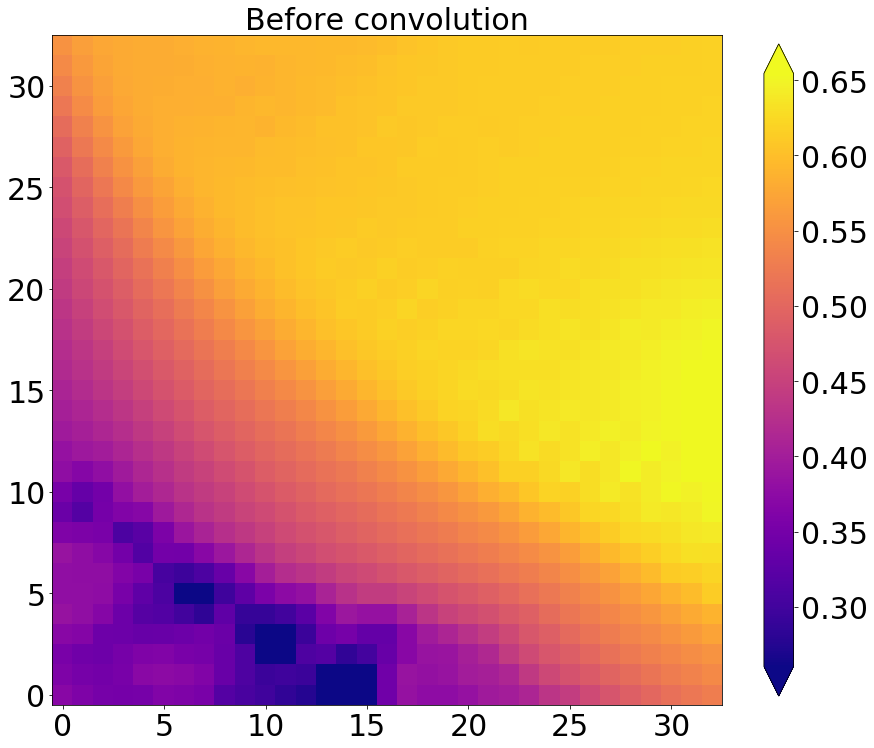

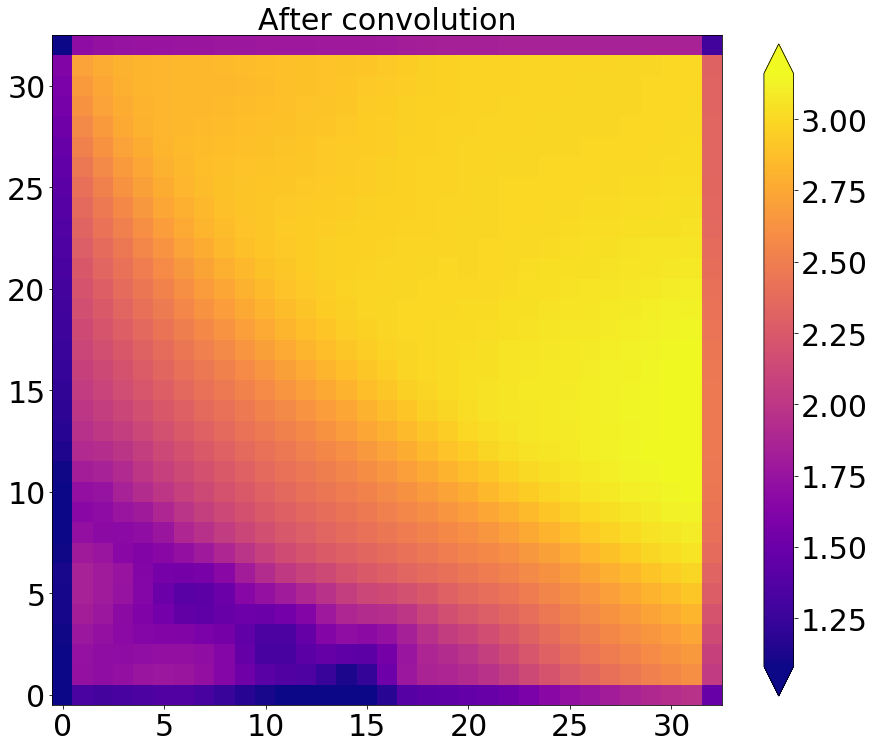

In [31]:
num_kernel_rows = 3
num_kernel_columns = 3

predictor_matrix = training_example_dict[PREDICTOR_MATRIX_KEY]
wet_bulb_theta_index = predictor_names.index(WET_BULB_THETA_NAME)
wet_bulb_theta_matrix = predictor_matrix[0, ..., wet_bulb_theta_index]

plot_feature_map(wet_bulb_theta_matrix)
pyplot.title('Before convolution')

feature_matrix = numpy.expand_dims(wet_bulb_theta_matrix, axis=-1)
kernel_matrix = numpy.random.uniform(
    low=0., high=1., size=(num_kernel_rows, num_kernel_columns, 1, 1))

feature_matrix = do_2d_conv(
    feature_matrix=feature_matrix, kernel_matrix=kernel_matrix,
    pad_edges=True, stride_length_px=1)
feature_matrix = feature_matrix[0, ..., 0]
plot_feature_map(feature_matrix)
pyplot.title('After convolution')

The next cell does not use edge-padding, which removes artifacts around the edge of the output feature map ("after convolution").

Text(0.5,1,'After convolution')

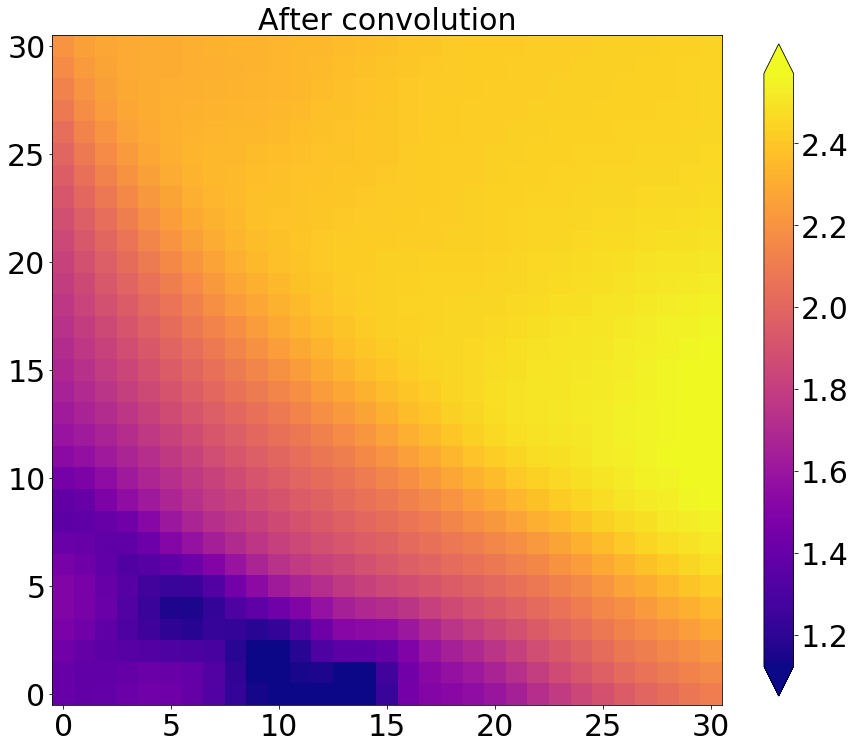

In [32]:
num_kernel_rows = 3
num_kernel_columns = 3

predictor_matrix = training_example_dict[PREDICTOR_MATRIX_KEY]
wet_bulb_theta_index = predictor_names.index(WET_BULB_THETA_NAME)
wet_bulb_theta_matrix = predictor_matrix[0, ..., wet_bulb_theta_index]
feature_matrix = numpy.expand_dims(wet_bulb_theta_matrix, axis=-1)

kernel_matrix = numpy.random.uniform(
    low=0., high=1., size=(num_kernel_rows, num_kernel_columns, 1, 1))

feature_matrix = do_2d_conv(
    feature_matrix=feature_matrix, kernel_matrix=kernel_matrix,
    pad_edges=False, stride_length_px=1)
feature_matrix = feature_matrix[0, ..., 0]
plot_feature_map(feature_matrix)
pyplot.title('After convolution')

The next cell does "strided convolution," with a stride length of 2 grid cells.  The original grid cells were 32 x 32 km.  The new ones are 64 x 64 km (the grid spacing is multiplied by the stride length).

Text(0.5,1,'After convolution')

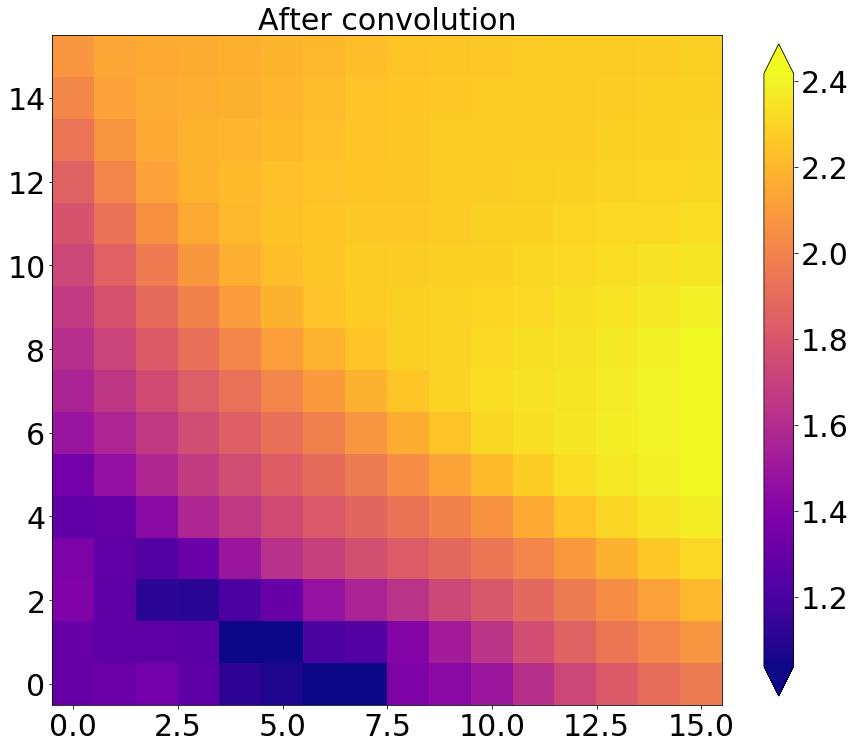

In [33]:
num_kernel_rows = 3
num_kernel_columns = 3

predictor_matrix = training_example_dict[PREDICTOR_MATRIX_KEY]
wet_bulb_theta_index = predictor_names.index(WET_BULB_THETA_NAME)
wet_bulb_theta_matrix = predictor_matrix[0, ..., wet_bulb_theta_index]
feature_matrix = numpy.expand_dims(wet_bulb_theta_matrix, axis=-1)

kernel_matrix = numpy.random.uniform(
    low=0., high=1., size=(num_kernel_rows, num_kernel_columns, 1, 1))

feature_matrix = do_2d_conv(
    feature_matrix=feature_matrix, kernel_matrix=kernel_matrix,
    pad_edges=False, stride_length_px=2)
feature_matrix = feature_matrix[0, ..., 0]
plot_feature_map(feature_matrix)
pyplot.title('After convolution')

The next cell does convolution with stride length = 1 and no edge-padding, so it similar to the example two cells above.  The difference is that now the kernel is pre-determined, instead of randomly generated.  The pre-determined kernel is known to be a good edge-detector.

Text(0.5,1,'After convolution')

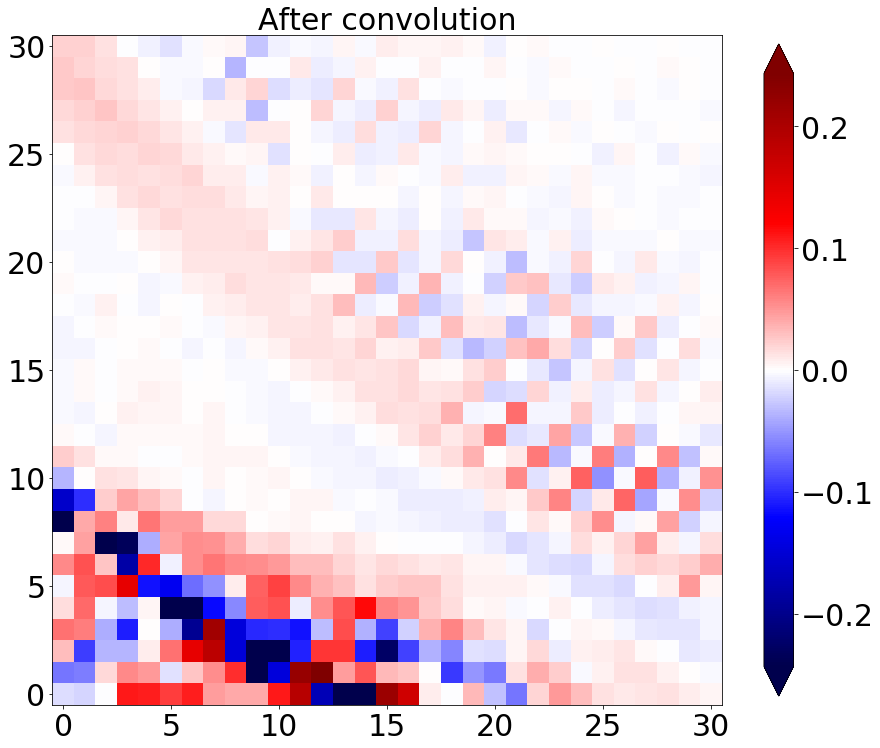

In [34]:
predictor_matrix = training_example_dict[PREDICTOR_MATRIX_KEY]
wet_bulb_theta_index = predictor_names.index(WET_BULB_THETA_NAME)
wet_bulb_theta_matrix = predictor_matrix[0, ..., wet_bulb_theta_index]
feature_matrix = numpy.expand_dims(wet_bulb_theta_matrix, axis=-1)

kernel_matrix = numpy.expand_dims(EDGE_DETECTOR_MATRIX1, axis=-1)
kernel_matrix = numpy.expand_dims(kernel_matrix, axis=-1)

feature_matrix = do_2d_conv(
    feature_matrix=feature_matrix, kernel_matrix=kernel_matrix,
    pad_edges=False, stride_length_px=1)
feature_matrix = feature_matrix[0, ..., 0]

max_colour_value = numpy.percentile(numpy.absolute(feature_matrix), 99.)
min_colour_value = -1 * max_colour_value
plot_feature_map(
    feature_matrix, colour_map_object=pyplot.cm.seismic,
    min_colour_value=min_colour_value, max_colour_value=max_colour_value)
pyplot.title('After convolution')

The next cell is the same, except that it uses a different edge-detector kernel.

Text(0.5,1,'After convolution')

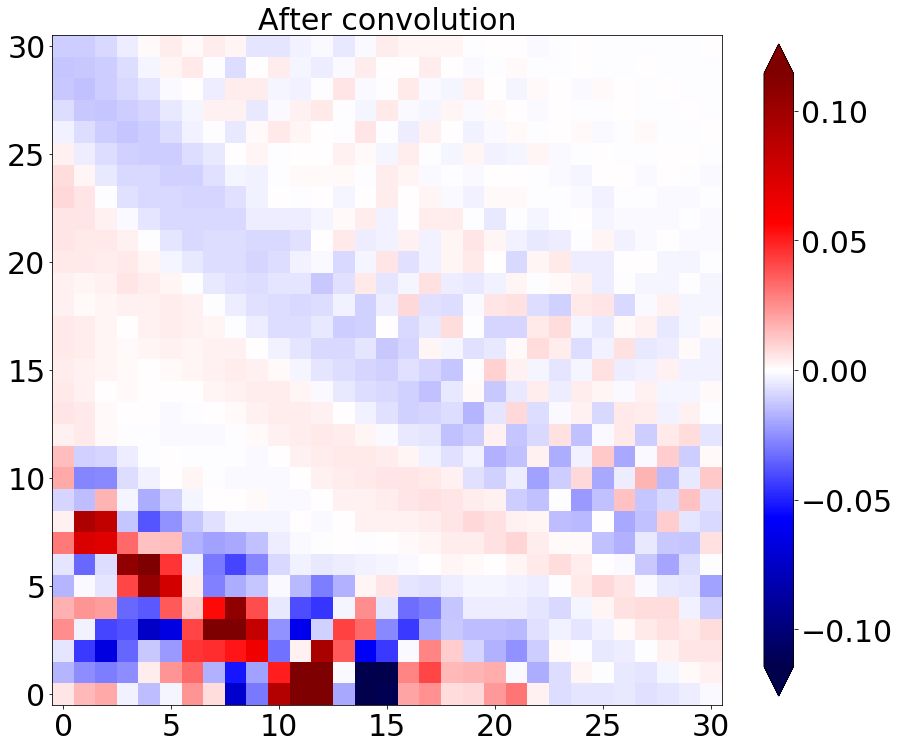

In [35]:
predictor_matrix = training_example_dict[PREDICTOR_MATRIX_KEY]
wet_bulb_theta_index = predictor_names.index(WET_BULB_THETA_NAME)
wet_bulb_theta_matrix = predictor_matrix[0, ..., wet_bulb_theta_index]
feature_matrix = numpy.expand_dims(wet_bulb_theta_matrix, axis=-1)

kernel_matrix = numpy.expand_dims(EDGE_DETECTOR_MATRIX2, axis=-1)
kernel_matrix = numpy.expand_dims(kernel_matrix, axis=-1)

feature_matrix = do_2d_conv(
    feature_matrix=feature_matrix, kernel_matrix=kernel_matrix,
    pad_edges=False, stride_length_px=1)
feature_matrix = feature_matrix[0, ..., 0]

max_colour_value = numpy.percentile(numpy.absolute(feature_matrix), 99.)
min_colour_value = -1 * max_colour_value
plot_feature_map(
    feature_matrix, colour_map_object=pyplot.cm.seismic,
    min_colour_value=min_colour_value, max_colour_value=max_colour_value)
pyplot.title('After convolution')

The next cell tries a third edge-detector kernel.

Text(0.5,1,'After convolution')

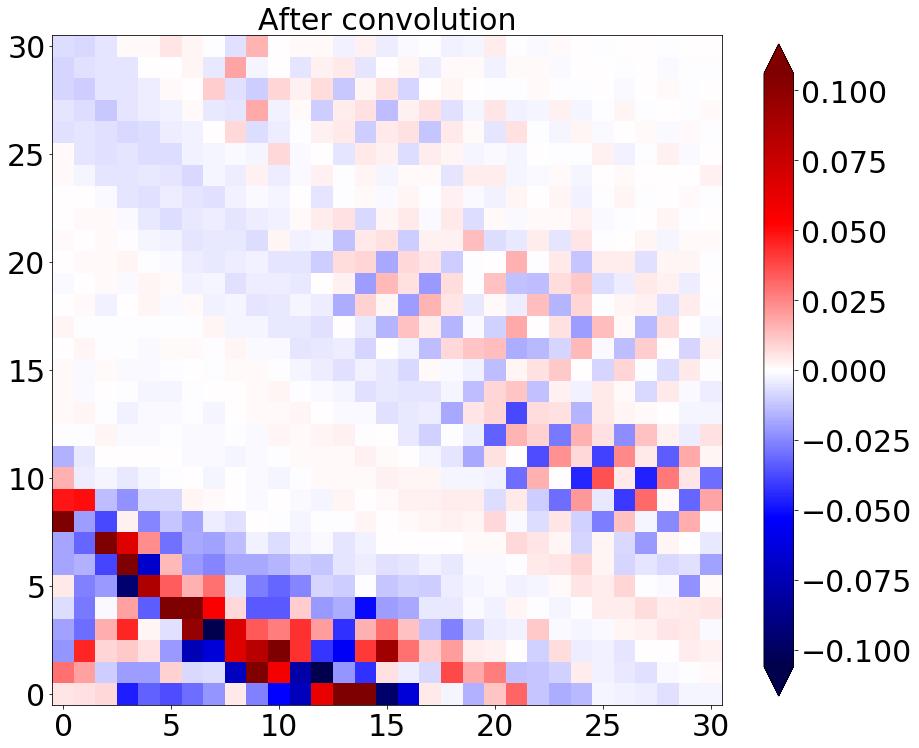

In [36]:
predictor_matrix = training_example_dict[PREDICTOR_MATRIX_KEY]
wet_bulb_theta_index = predictor_names.index(WET_BULB_THETA_NAME)
wet_bulb_theta_matrix = predictor_matrix[0, ..., wet_bulb_theta_index]
feature_matrix = numpy.expand_dims(wet_bulb_theta_matrix, axis=-1)

kernel_matrix = numpy.expand_dims(EDGE_DETECTOR_MATRIX3, axis=-1)
kernel_matrix = numpy.expand_dims(kernel_matrix, axis=-1)

feature_matrix = do_2d_conv(
    feature_matrix=feature_matrix, kernel_matrix=kernel_matrix,
    pad_edges=False, stride_length_px=1)
feature_matrix = feature_matrix[0, ..., 0]

max_colour_value = numpy.percentile(numpy.absolute(feature_matrix), 99.)
min_colour_value = -1 * max_colour_value
plot_feature_map(
    feature_matrix, colour_map_object=pyplot.cm.seismic,
    min_colour_value=min_colour_value, max_colour_value=max_colour_value)
pyplot.title('After convolution')

The next cell does multi-channel convolution and requires more explanation.

/home/ryan.lagerquist/anaconda2_general_exam/lib/python2.7/site-packages/GewitterGefahr-0.1-py2.7.egg/gewittergefahr/gg_utils/error_checking.py:251: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not numpy.issubdtype(input_variable.dtype, int):


Text(0.5,1,'Filter 2 after convolution')

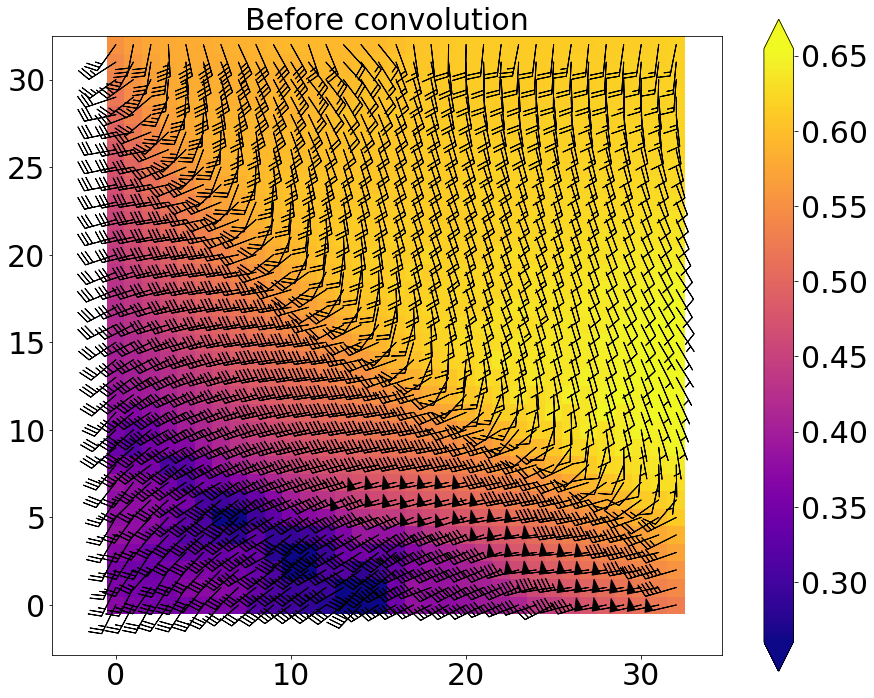

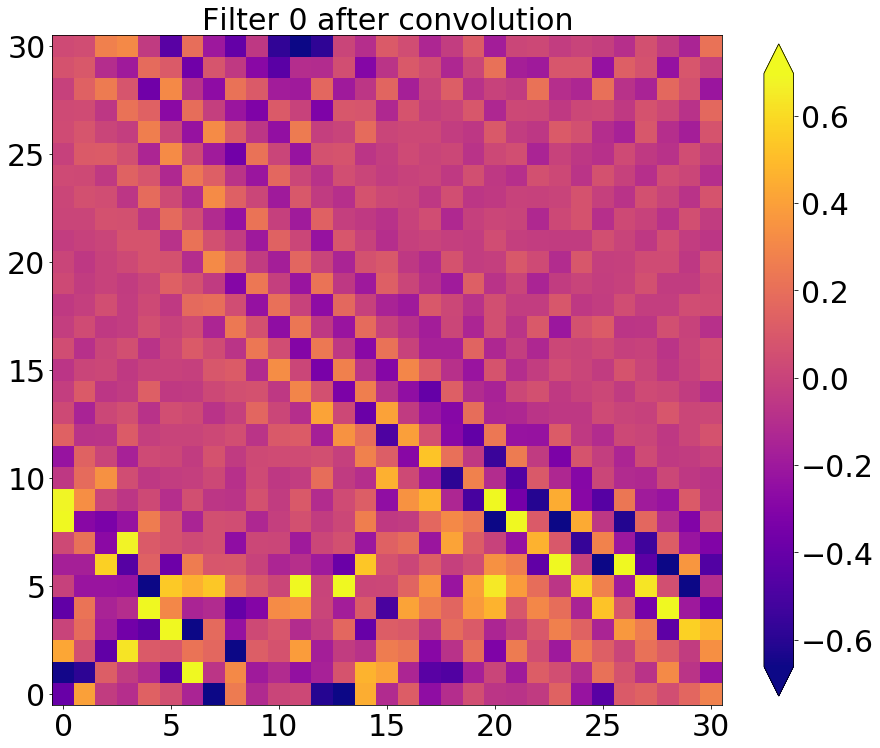

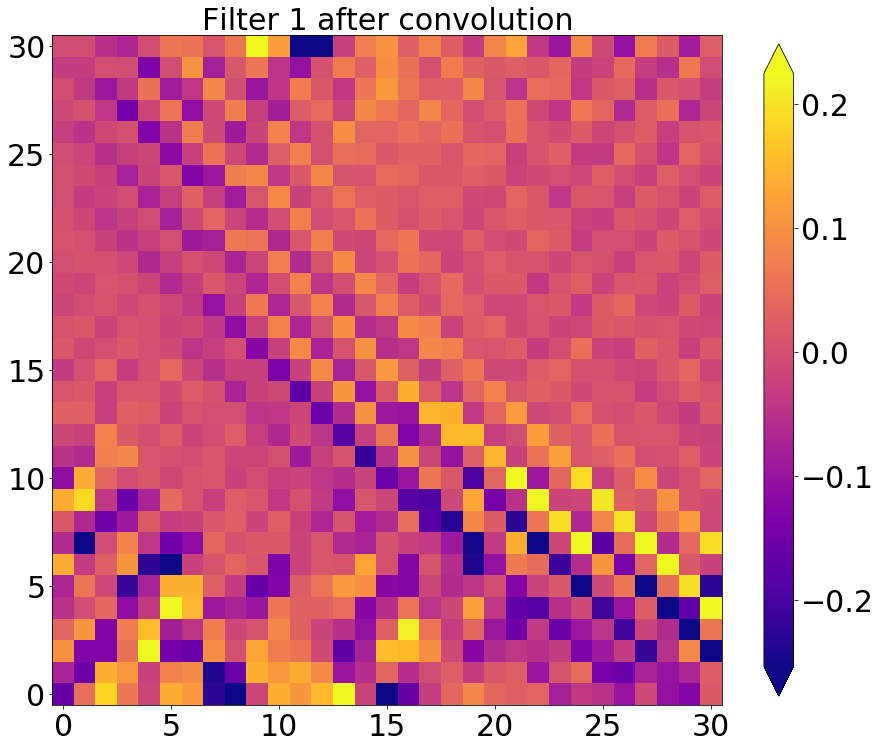

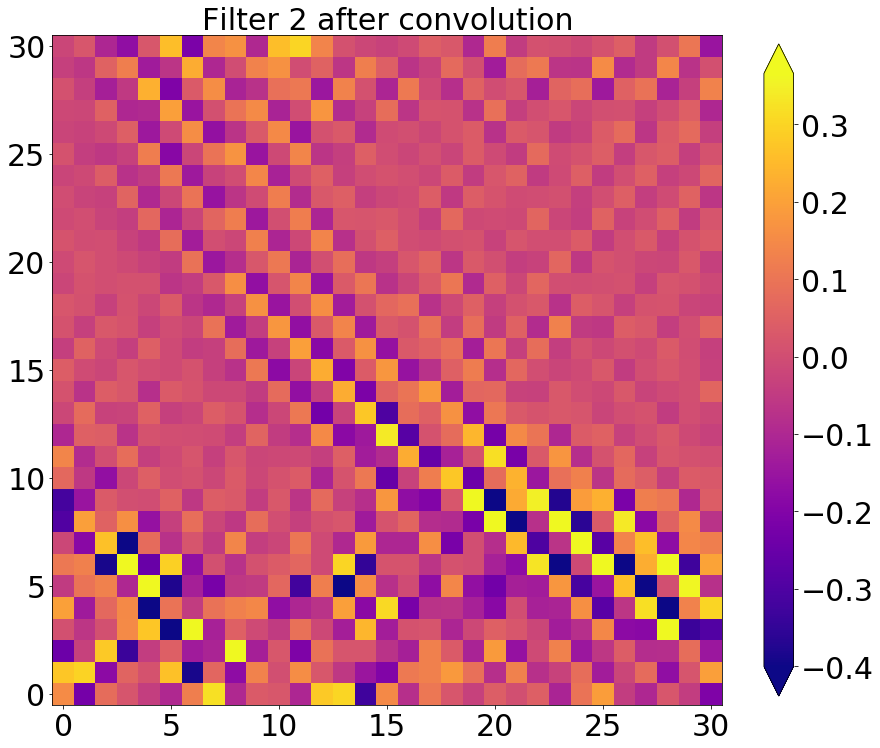

In [37]:
predictor_matrix = training_example_dict[PREDICTOR_MATRIX_KEY]
wet_bulb_theta_index = predictor_names.index(WET_BULB_THETA_NAME)
u_wind_index = predictor_names.index(U_WIND_GRID_RELATIVE_NAME)
v_wind_index = predictor_names.index(V_WIND_GRID_RELATIVE_NAME)

wet_bulb_theta_matrix = predictor_matrix[0, ..., wet_bulb_theta_index]
u_wind_matrix = predictor_matrix[0, ..., u_wind_index]
v_wind_matrix = predictor_matrix[0, ..., v_wind_index]

axes_object = plot_feature_map(feature_matrix=wet_bulb_theta_matrix)
plot_wind_barbs(
    u_wind_matrix=u_wind_matrix, v_wind_matrix=v_wind_matrix,
    axes_object=axes_object)
pyplot.title('Before convolution')

kernel_matrix_to_channel0 = numpy.stack(
    (EDGE_DETECTOR_MATRIX1, EDGE_DETECTOR_MATRIX1, EDGE_DETECTOR_MATRIX1),
    axis=-1)
kernel_matrix_to_channel1 = numpy.stack(
    (EDGE_DETECTOR_MATRIX2, EDGE_DETECTOR_MATRIX2, EDGE_DETECTOR_MATRIX2),
    axis=-1)
kernel_matrix_to_channel2 = numpy.stack(
    (EDGE_DETECTOR_MATRIX3, EDGE_DETECTOR_MATRIX3, EDGE_DETECTOR_MATRIX3),
    axis=-1)
kernel_matrix = numpy.stack(
    (kernel_matrix_to_channel0, kernel_matrix_to_channel1,
     kernel_matrix_to_channel2),
    axis=-1)

feature_matrix = numpy.stack(
    (wet_bulb_theta_matrix, u_wind_matrix, v_wind_matrix), axis=-1)
feature_matrix = do_2d_conv(
    feature_matrix=feature_matrix, kernel_matrix=kernel_matrix,
    pad_edges=False, stride_length_px=1)
feature_matrix = feature_matrix[0, ...]

plot_feature_map(feature_matrix=feature_matrix[..., 0])
pyplot.title('Filter 0 after convolution')

plot_feature_map(feature_matrix=feature_matrix[..., 1])
pyplot.title('Filter 1 after convolution')

plot_feature_map(feature_matrix=feature_matrix[..., 2])
pyplot.title('Filter 2 after convolution')

The following method passes an array of input values through an activation function.

In [47]:
def do_activation(input_values, function_name, slope=0.2):
    """Computes activation of input array.

    :param input_values: numpy array of input values.
    :param function_name: Name of activation function.
    :param slope: Slope for eLU or leaky ReLU function.
    :return: output_values: Equivalent-size numpy array of output values (post-
        activation).
    """

    input_object = K.placeholder()

    if function_name.lower() == 'elu':
        function_object = K.function(
            [input_object],
            [keras.layers.ELU(alpha=slope)(input_object)]
        )
    elif function_name.lower() == 'leakyrelu':
        function_object = K.function(
            [input_object],
            [keras.layers.LeakyReLU(alpha=slope)(input_object)]
        )
    else:
        function_object = K.function(
            [input_object],
            [keras.layers.Activation(function_name)(input_object)]
        )

    return function_object([input_values])[0]

The next cell graphs the behaviour of a few standard activation functions.

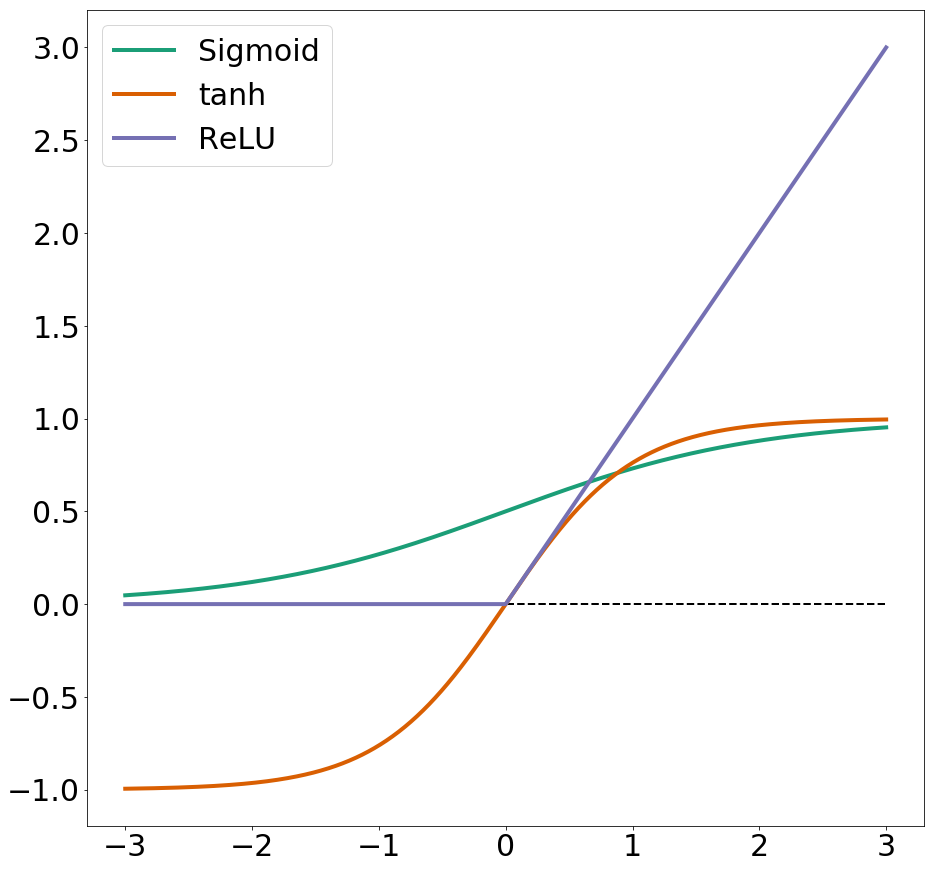

In [48]:
function_names_keras = ['sigmoid', 'tanh', 'relu']
function_names_fancy = ['Sigmoid', 'tanh', 'ReLU']
input_values = numpy.linspace(-3, 3, num=1000, dtype=float)

line_width = 4
colour_by_function = numpy.array([[27, 158, 119],
                                  [217, 95, 2],
                                  [117, 112, 179]], dtype=float) / 255

_, axes_object = pyplot.subplots(
    1, 1, figsize=(FIGURE_WIDTH_INCHES, FIGURE_HEIGHT_INCHES))

pyplot.plot(
    input_values, numpy.zeros(input_values.shape),
    linewidth=line_width / 2, linestyle='dashed', color=numpy.full(3, 0.))

for i in range(len(function_names_keras)):
    these_output_values = do_activation(
        input_values=input_values, function_name=function_names_keras[i])

    pyplot.plot(
        input_values, these_output_values,
        linewidth=line_width, linestyle='solid',
        color=colour_by_function[i, :], label=function_names_fancy[i])

pyplot.legend()

The next cell graphs the behaviour of a few fancier activation functions: leaky ReLU (rectified linear unit), eLU (exponential linear unit), and SeLU (scaled exponential linear unit).

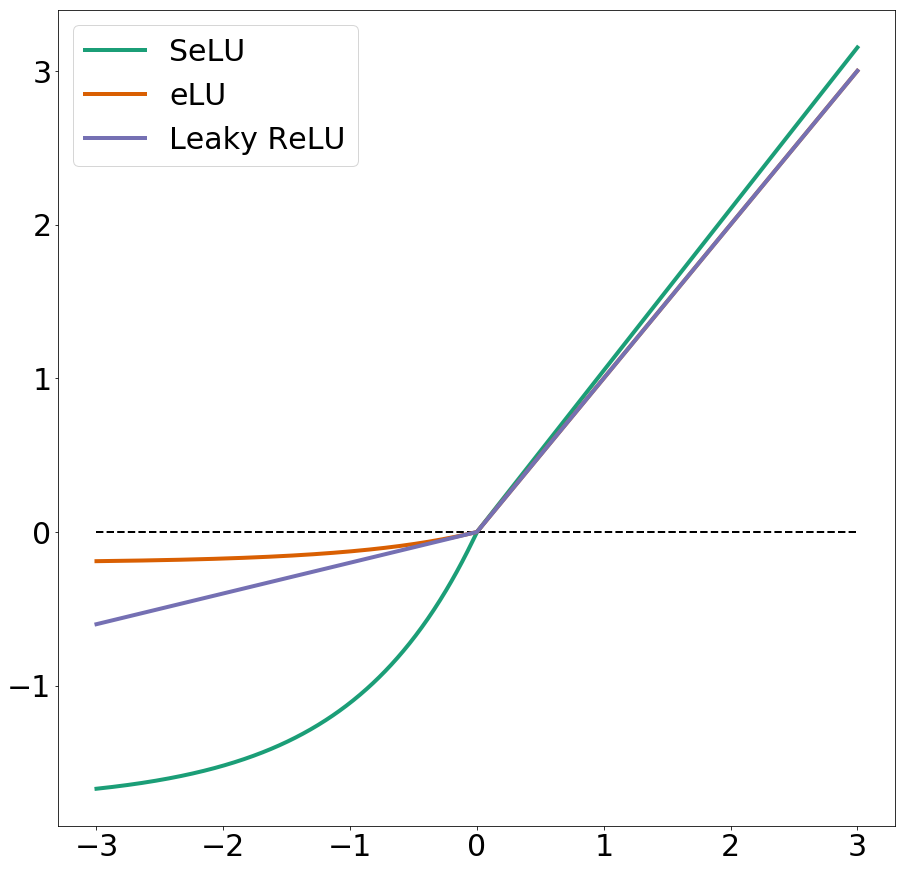

In [49]:
function_names_keras = ['selu', 'elu', 'LeakyReLU']
function_names_fancy = ['SeLU', 'eLU', 'Leaky ReLU']
input_values = numpy.linspace(-3, 3, num=1000, dtype=float)

line_width = 4
colour_by_function = numpy.array([[27, 158, 119],
                                  [217, 95, 2],
                                  [117, 112, 179]], dtype=float) / 255

_, axes_object = pyplot.subplots(
    1, 1, figsize=(FIGURE_WIDTH_INCHES, FIGURE_HEIGHT_INCHES))

pyplot.plot(
    input_values, numpy.zeros(input_values.shape),
    linewidth=line_width / 2, linestyle='dashed', color=numpy.full(3, 0.))

for i in range(len(function_names_keras)):
    these_output_values = do_activation(
        input_values=input_values, function_name=function_names_keras[i],
        slope=0.2)

    pyplot.plot(
        input_values, these_output_values,
        linewidth=line_width, linestyle='solid',
        color=colour_by_function[i, :], label=function_names_fancy[i])

pyplot.legend()

The next performs stand-alone 2-D pooling (not as part of CNN-training).

In [51]:
def do_2d_pooling(feature_matrix, stride_length_px=2, type_string='max'):
    """Performs max-pooling on 2-D feature map.

    M = number of rows before pooling
    N = number of columns before pooling
    P = number of channels in input feature map

    m = number of rows after pooling
    n = number of columns after pooling

    :param feature_matrix: Feature map as numpy array.  Dimensions may be
        M x N x P or 1 x M x N x P.  Either way, it will be converted to
        1 x M x N x P before pooling.
    :param stride_length_px: Stride length.  The pooling window will move this
        many pixels (rows or columns) at a time as it passes over the image.
        Both the row and column dimensions will be decreased by a factor of
        `stride_length_px`.
    :param type_string: Type of pooling ("max" or "mean").
    :return: feature_matrix: New feature map (1 x m x n x P).
    """

    if feature_matrix.shape[0] != 1:
        feature_matrix = numpy.expand_dims(feature_matrix, axis=0)

    error_checking.assert_is_integer(stride_length_px)
    error_checking.assert_is_geq(stride_length_px, 2)
    error_checking.assert_is_string(type_string)

    feature_tensor = K.pool2d(
        x=K.variable(feature_matrix), pool_mode=type_string,
        pool_size=(stride_length_px, stride_length_px),
        strides=(stride_length_px, stride_length_px), padding='valid',
        data_format='channels_last')
    return feature_tensor.eval(session=K.get_session())

The next cell applies max-pooling, with stride length = 2, to an input iamge (grid of wet-bulb potential temperature).

Text(0.5,1,'After max-pooling')

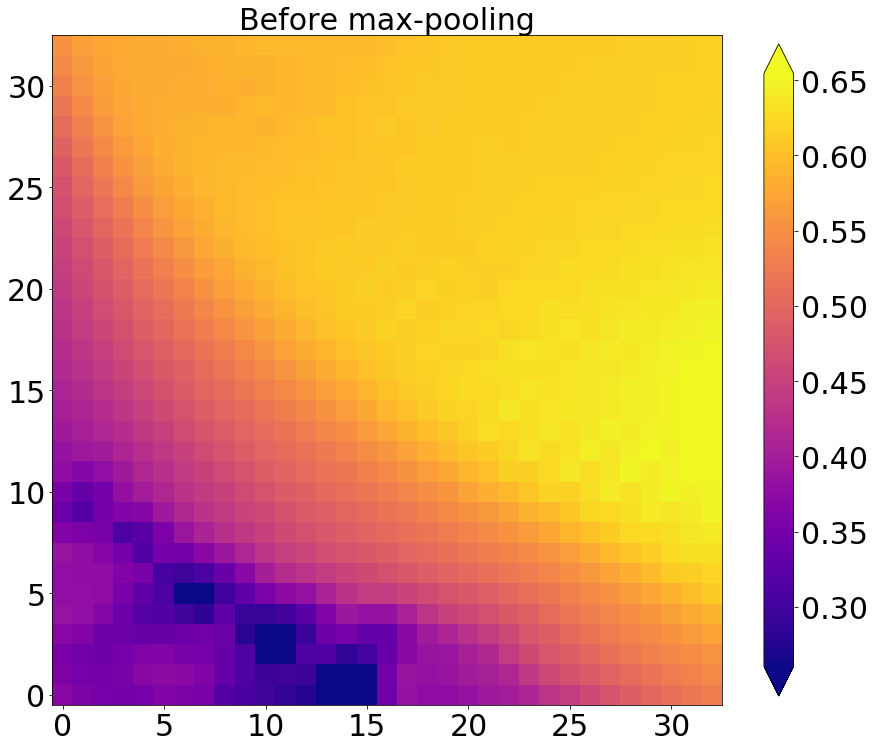

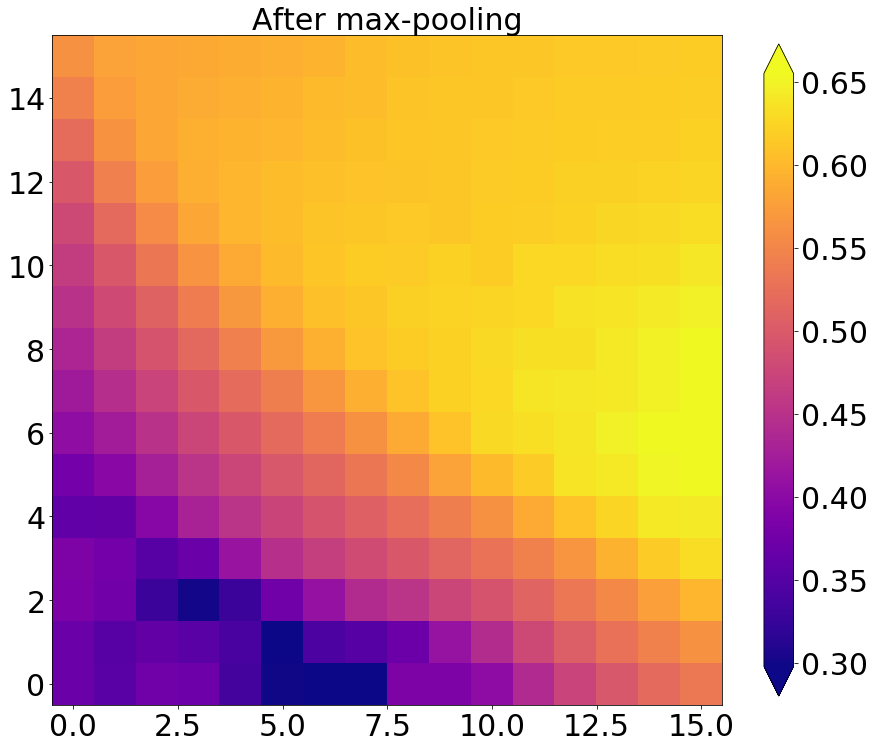

In [52]:
predictor_matrix = training_example_dict[PREDICTOR_MATRIX_KEY]
wet_bulb_theta_index = predictor_names.index(WET_BULB_THETA_NAME)
wet_bulb_theta_matrix = predictor_matrix[0, ..., wet_bulb_theta_index]

plot_feature_map(wet_bulb_theta_matrix)
pyplot.title('Before max-pooling')

feature_matrix = numpy.expand_dims(wet_bulb_theta_matrix, axis=-1)
feature_matrix = do_2d_pooling(
    feature_matrix=feature_matrix, stride_length_px=2, type_string='max')
feature_matrix = feature_matrix[0, ..., 0]

plot_feature_map(feature_matrix)
pyplot.title('After max-pooling')

The next cell does mean-pooling instead of max-pooling.

Text(0.5,1,'After mean-pooling')

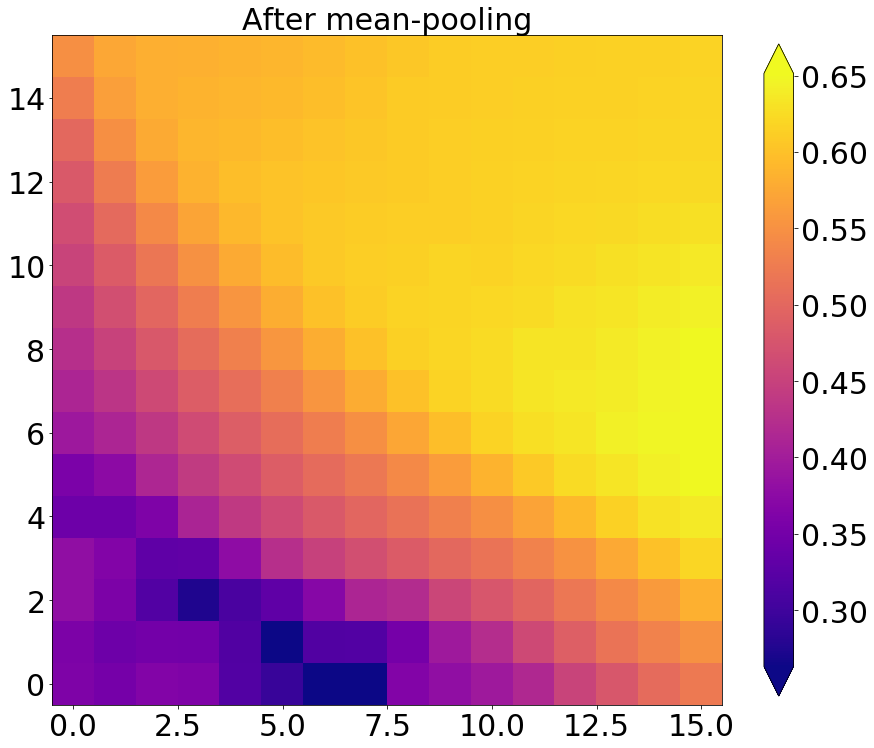

In [55]:
predictor_matrix = training_example_dict[PREDICTOR_MATRIX_KEY]
wet_bulb_theta_index = predictor_names.index(WET_BULB_THETA_NAME)
wet_bulb_theta_matrix = predictor_matrix[0, ..., wet_bulb_theta_index]
feature_matrix = numpy.expand_dims(wet_bulb_theta_matrix, axis=-1)

feature_matrix = do_2d_pooling(
    feature_matrix=feature_matrix, stride_length_px=2, type_string='avg')
feature_matrix = feature_matrix[0, ..., 0]

plot_feature_map(feature_matrix)
pyplot.title('After mean-pooling')

The next cell does mean-pooling with a stride length of 4 instead of 2.

Text(0.5,1,'After mean-pooling')

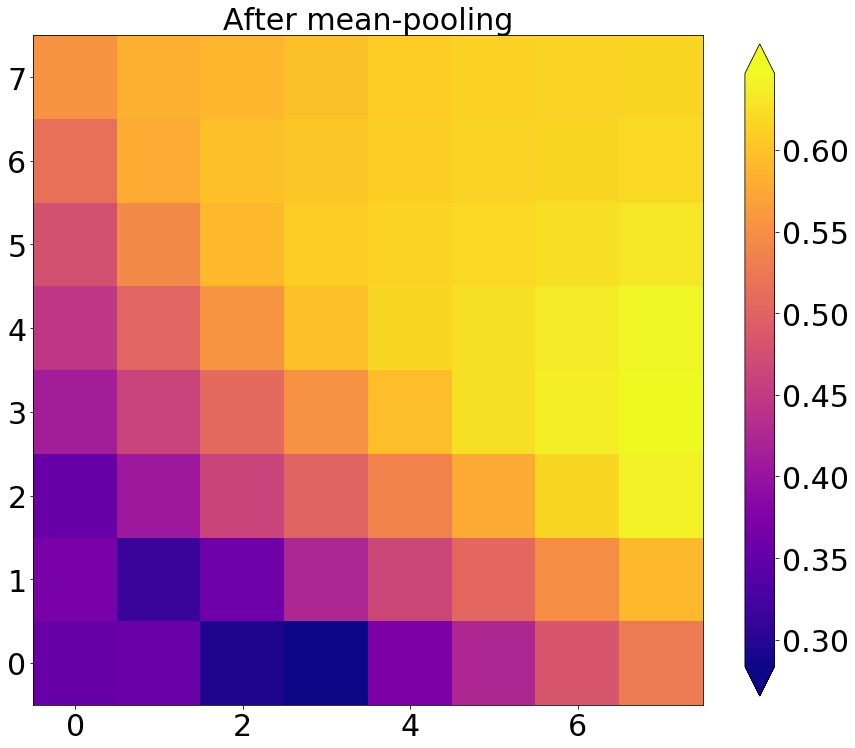

In [56]:
predictor_matrix = training_example_dict[PREDICTOR_MATRIX_KEY]
wet_bulb_theta_index = predictor_names.index(WET_BULB_THETA_NAME)
wet_bulb_theta_matrix = predictor_matrix[0, ..., wet_bulb_theta_index]
feature_matrix = numpy.expand_dims(wet_bulb_theta_matrix, axis=-1)

feature_matrix = do_2d_pooling(
    feature_matrix=feature_matrix, stride_length_px=4, type_string='avg')
feature_matrix = feature_matrix[0, ..., 0]

plot_feature_map(feature_matrix)
pyplot.title('After mean-pooling')